In [108]:
import numpy as np
from sympy import symbols, simplify, Matrix

class LaplaceCircuitAnalyzer:
    def __init__(self, nodes, branches):
        """
        Initialize circuit analyzer for Laplace domain analysis.
        """
        self.nodes = nodes
        self.branches = branches
        self.incidence_matrix = None
        self.s = symbols('s')  # Laplace variable
        self.branch_impedances = []
        self.voltage_sources = []
        self.current_sources= []
        self.tie_sets = []
        self.cut_sets = []

    def set_incidence_matrix(self, matrix):
        """
        Set the incidence matrix for the circuit.
        """
        self.incidence_matrix = np.array(matrix)

    def set_branch_components(self, resistors, inductors, capacitors, voltages, currents):
        """
        Set branch components and voltage sources in Laplace domain.
        """
        self.branch_impedances = []
        for r, l, c, v, i in zip(resistors, inductors, capacitors, voltages, currents):
            if r!=0:
                impedance=r
                self.branch_impedances.append(impedance)
            elif c!=0:
                impedance=c
                self.branch_impedances.append(impedance)
            elif l!=0:
                impedance=l
                self.branch_impedances.append(impedance)
            elif v!=0:
                self.branch_impedances.append(0)
            elif i!=0:
                self.branch_impedances.append(0)
            
        self.voltage_sources = [v for v in voltages]  # Divide each voltage source by s
        self.current_sources = [i for i in currents]  # Divide each current source by s


    def find_tie_sets(self):
        """
        Find fundamental tie sets using incidence matrix.
        """
        A = Matrix(self.incidence_matrix[:-1, :])  # Use symbolic matrix for SVD
        rank = A.rank()
        num_ties = self.branches - rank  # Number of tie sets = branches - rank
        null_space = A.nullspace()  # Find the null space vectors

        # Ensure the number of tie sets matches expected output
        self.tie_sets = Matrix.hstack(*null_space).T[:num_ties, :]  # Transpose to get correct shape
        return self.tie_sets


    def find_cut_sets(self):
        """
        Find fundamental cut sets from incidence matrix.
        """
        self.cut_sets = self.incidence_matrix[:-1, :]  # Use the reduced incidence matrix
        return self.cut_sets

    def solve_currents(self):
        """
        Solve for branch currents in Laplace domain.
        """
        # Ensure all matrices are symbolic
        B = Matrix(self.tie_sets)
        Z = Matrix.diag(*self.branch_impedances)  # Symbolic diagonal matrix
        E = Matrix(self.voltage_sources)

        # Solve BZB'i = -BE
        BZBt = B * Z * B.T
        BE = B * E
        try:
            mesh_currents = BZBt.inv() * (-BE)  # Mesh currents
            branch_currents = B.T * mesh_currents  # Branch currents
            return [simplify(current) for current in branch_currents]
        except Exception as e:
            return f"System could not be solved symbolically: {str(e)}"

    def solve_currents_no_voltage_sources(self):
        """
        Solve for branch currents in Laplace domain for circuits without voltage sources,
        using current sources as driving elements.
        """
        # Ensure all matrices are symbolic
        B = Matrix(self.tie_sets)
        Z = Matrix.diag(*self.branch_impedances)  # Symbolic diagonal impedance matrix
        I = Matrix(self.current_sources)
    
        try:
            # Compute node voltages
            BZBt_inv = (B * Z.inv() * B.T).inv()
            V_nodes = BZBt_inv * (B * I)
    
            # Compute branch voltages
            V_branches = B.T * V_nodes
    
            # Compute branch currents
            branch_currents = Z.inv() * V_branches
            return {
                [simplify(i) for i in branch_currents]
            }
        except Exception as e:
            return f"System could not be solved symbolically: {str(e)}"


    def solve_voltages(self):
        """
        Solve for branch voltages in Laplace domain.
        """
        try:
            # Solve for branch currents first
            branch_currents = self.solve_currents()
            if isinstance(branch_currents, str):  # If currents cannot be solved
                return "Branch currents could not be solved, so voltages cannot be computed."
        
            # Convert branch currents to a symbolic matrix
            I_b = Matrix(branch_currents)
        
            # Calculate branch voltages: V_b = Z * I_b
            Z = Matrix(np.diag(self.branch_impedances))  # Impedance matrix
            branch_voltages = Z * I_b  # Branch voltages
        
            # Simplify results
            return [simplify(voltage) for voltage in branch_voltages]
        except Exception as e:
            return f"An error occurred while solving voltages: {e}"

    def solve_voltages_no_voltages(self):
        """
        Solve for branch voltages in Laplace domain.
        """
        # Ensure all matrices are symbolic
        B = Matrix(self.tie_sets)
        Z = Matrix.diag(*self.branch_impedances)  # Symbolic diagonal impedance matrix
        I = Matrix(self.current_sources)
        
        try:
            # Compute node voltages
            BZBt_inv = (B * Z.inv() * B.T).inv()
            V_nodes = BZBt_inv * (B * I)
    
            # Compute branch voltages
            V_branches = B.T * V_nodes
        
            # Simplify results
            return [simplify(voltage) for voltage in branch_voltages]
        except Exception as e:
            return f"An error occurred while solving voltages: {e}"


# Sandeep's Part

In [114]:
from sympy import symbols, Matrix, Rational

# Define the Laplace variable
s = symbols('s')

def get_laplace_values():
    """
    Collects element details (R, L, C, V, I) and their node locations, 
    calculates Laplace-transformed impedances, and ensures at least one V or I is present.
    """
    # Input the number of nodes and elements
    nodes = int(input("Enter the number of nodes: "))
    elements = int(input("Enter the number of elements (R, L, C, V, I): "))

    while elements < 1:
        print("The circuit must have at least one element. Please re-enter.")
        elements = int(input("Enter the number of elements (R, L, C, V, I): "))

    # Initialize storages
    resistors, inductors, capacitors = [], [], []
    voltage_sources, current_sources = [], []

    pos_nodes, neg_nodes = [], []  # Positive/negative nodes
    has_voltage_source = has_current_source = False

    for i in range(elements):
        print(f"\nElement {i + 1}:")
        element_type = input("Enter type (R, L, C, V, I): ").strip().upper()
        pos_node = int(input(f"Enter the positive node (0-{nodes - 1}): "))
        neg_node = int(input(f"Enter the negative node (0-{nodes - 1}): "))

        pos_nodes.append(pos_node)
        neg_nodes.append(neg_node)

        if element_type in ('R', 'L', 'C'):
            value = float(input("Enter the value: "))

        if element_type == 'R':
            resistors.append(value)
            inductors.append(0)
            capacitors.append(0)
            voltage_sources.append(0)
            current_sources.append(0)
        elif element_type == 'L':
            inductors.append(value * s)  # Transforms to sL
            resistors.append(0)
            capacitors.append(0)
            voltage_sources.append(0)
            current_sources.append(0)
        elif element_type == 'C':
            capacitors.append(1/ (value * s))  # Transforms to 1/(sC)
            resistors.append(0)
            inductors.append(0)
            voltage_sources.append(0)
            current_sources.append(0)
        elif element_type == 'V':
            value = float(input("Enter the voltage value: "))
            voltage_sources.append(value * (1/ (s)))
            capacitors.append(0)  # Transforms to 1/(sC)
            resistors.append(0)
            inductors.append(0)
            current_sources.append(0)
            has_voltage_source = True
        elif element_type == 'I':
            value = float(input("Enter the current value: "))
            current_sources.append(value * (1/ (s)))
            capacitors.append(0)  # Transforms to 1/(sC)
            resistors.append(0)
            inductors.append(0)
            voltage_sources.append(0)
            has_current_source = True
        else:
            print("Invalid element type. Please enter R, L, C, V, or I.")

    if not (has_voltage_source or has_current_source):
        print("\nError: At least one voltage source (V) or current source (I) must be present.")
        return get_laplace_values()

    return nodes, elements, resistors, inductors, capacitors, voltage_sources, current_sources, pos_nodes, neg_nodes

def generate_incidence_matrix(nodes, elements, pos_nodes, neg_nodes):
    """
    Generates the incidence matrix for the given circuit.
    """
    incidence_matrix = [[0 for _ in range(elements)] for _ in range(nodes)]
    for index in range(elements):
        pos_node = pos_nodes[index]
        neg_node = neg_nodes[index]

        if pos_node != -1:
            incidence_matrix[pos_node][index] = 1
        if neg_node != -1:
            incidence_matrix[neg_node][index] = -1

    return Matrix(incidence_matrix)

def analyze_example_rlc_circuit(nodes, elements, incidence_matrix, resistors, inductors, capacitors, voltage_sources, current_sources):
    analyzer = LaplaceCircuitAnalyzer(nodes=nodes, branches=elements)
    
    # Convert symbolic elements to numeric (if necessary) for computation
    numeric_incidence_matrix = Matrix(incidence_matrix).evalf()

    analyzer.set_incidence_matrix(numeric_incidence_matrix)
    analyzer.set_branch_components(
        [float(r) for r in resistors],
        [inductor.evalf() if inductor != 0 else 0 for inductor in inductors],
        [capacitor.evalf() if capacitor != 0 else 0 for capacitor in capacitors],
        voltage_sources,
        current_sources
    )
    
    tie_sets = analyzer.find_tie_sets()
    cut_sets = analyzer.find_cut_sets()
    if voltage_sources:
        currents = analyzer.solve_currents()
        voltages = analyzer.solve_voltages()
    elif not voltage_sources:
        currents = analyzer.solve_currents_no_voltage_sources()
        voltages = analyzer.solve_voltages_no_voltage_sources()
    
    return {
        'tie_sets': tie_sets,
        'cut_sets': cut_sets,
        'currents': currents,
        'voltages': voltages
    }


In [118]:
nodes, elements, resistors, inductors, capacitors, voltage_sources, current_sources, pos_nodes, neg_nodes = get_laplace_values()

# Step 2: Generate the incidence matrix
incidence_matrix = generate_incidence_matrix(nodes, elements, pos_nodes, neg_nodes)

# Step 3: Display collected data
print("\nResistor values:", resistors)
print("Inductor values:", inductors)
print("Capacitor values:", capacitors)
print("Voltage source values:", voltage_sources)
print("Current source values:", current_sources)
print("\nIncidence Matrix:")
print(incidence_matrix)

# Step 4: Analyze the circuit
analysis_results = analyze_example_rlc_circuit(
    nodes=nodes,
    elements=elements,
    incidence_matrix=incidence_matrix,
    resistors=resistors,
    inductors=inductors,
    capacitors=capacitors,
    voltage_sources=voltage_sources,
    current_sources=current_sources
)

# Step 5: Display analysis results
print("\nTie Sets:")
print(analysis_results['tie_sets'])
print("\nCut Sets:")
print(analysis_results['cut_sets'])
print("\nCurrents:")
print(analysis_results['currents'])
print("\nVoltages:")
print(analysis_results['voltages'])



Enter the number of nodes:  4
Enter the number of elements (R, L, C, V, I):  4



Element 1:


Enter type (R, L, C, V, I):  i
Enter the positive node (0-3):  0
Enter the negative node (0-3):  1
Enter the current value:  10



Element 2:


Enter type (R, L, C, V, I):  r
Enter the positive node (0-3):  1
Enter the negative node (0-3):  2
Enter the value:  1



Element 3:


Enter type (R, L, C, V, I):  r
Enter the positive node (0-3):  2
Enter the negative node (0-3):  3
Enter the value:  2



Element 4:


Enter type (R, L, C, V, I):  r
Enter the positive node (0-3):  3
Enter the negative node (0-3):  0
Enter the value:  1



Resistor values: [0, 1.0, 2.0, 1.0]
Inductor values: [0, 0, 0, 0]
Capacitor values: [0, 0, 0, 0]
Voltage source values: [0, 0, 0, 0]
Current source values: [10.0/s, 0, 0, 0]

Incidence Matrix:
Matrix([[1, 0, 0, -1], [-1, 1, 0, 0], [0, -1, 1, 0], [0, 0, -1, 1]])

Tie Sets:
Matrix([[1.00000000000000, 1.00000000000000, 1.00000000000000, 1]])

Cut Sets:
[[1.00000000000000 0 0 -1.00000000000000]
 [-1.00000000000000 1.00000000000000 0 0]
 [0 -1.00000000000000 1.00000000000000 0]]

Currents:
[0, 0, 0, 0]

Voltages:
[0, 0, 0, 0]


# Yesh's Part

# This is the part where inverse laplace is taken

In [97]:
from sympy import symbols, Matrix, inverse_laplace_transform, simplify, exp
from sympy.abc import t

def compute_inverse_laplace(analysis_results):
    """
    Computes the inverse Laplace transform of currents and voltages
    
    Parameters:
    analysis_results: dictionary containing 'currents' and 'voltages' in Laplace domain
    
    Returns:
    dictionary containing time-domain expressions for currents and voltages
    """
    s = symbols('s')
    time_domain_results = {'currents': [], 'voltages': []}
    
    # Helper function to safely compute inverse Laplace transform
    def safe_inverse_laplace(expr):
        try:
            # Convert expression to sympify if it's not already
            expr = simplify(expr)
            # Compute inverse Laplace transform
            time_expr = inverse_laplace_transform(expr, s, t)
            # Simplify the result
            return simplify(time_expr)
        except Exception as e:
            return f"Could not compute inverse transform: {str(e)}"
    
    # Process currents
    print("\nComputing inverse Laplace transform of currents...")
    for idx, current in enumerate(analysis_results['currents'], 1):
        time_domain_current = safe_inverse_laplace(current)
        time_domain_results['currents'].append({
            'branch': idx,
            'laplace_domain': current,
            'time_domain': time_domain_current
        })
    
    # Process voltages
    print("\nComputing inverse Laplace transform of voltages...")
    for idx, voltage in enumerate(analysis_results['voltages'], 1):
        time_domain_voltage = safe_inverse_laplace(voltage)
        time_domain_results['voltages'].append({
            'branch': idx,
            'laplace_domain': voltage,
            'time_domain': time_domain_voltage
        })
    
    return time_domain_results

def display_time_domain_results(time_domain_results):
    """
    Displays the time-domain results in a formatted manner
    """
    print("\n=== Time Domain Current Solutions ===")
    for result in time_domain_results['currents']:
        print(f"\nBranch {result['branch']}:")
        print(f"Laplace domain: {result['laplace_domain']}")
        print(f"Time domain: i(t) = {result['time_domain']}")
    
    print("\n=== Time Domain Voltage Solutions ===")
    for result in time_domain_results['voltages']:
        print(f"\nBranch {result['branch']}:")
        print(f"Laplace domain: {result['laplace_domain']}")
        print(f"Time domain: v(t) = {result['time_domain']}")

# Usage with your existing code
def process_circuit_solutions(analysis_results):
    """
    Process the circuit solutions and compute time domain expressions
    """
    # Compute inverse Laplace transforms
    time_domain_results = compute_inverse_laplace(analysis_results)
    
    # Display results
    display_time_domain_results(time_domain_results)
    
    return time_domain_results

# Add this to your main code after getting analysis_results
time_domain_solutions = process_circuit_solutions(analysis_results)

# Example of how to evaluate solutions at specific time points
def evaluate_at_time(time_domain_solutions, t_value):
    """
    Evaluates the time-domain solutions at a specific time point
    
    Parameters:
    time_domain_solutions: dictionary containing time-domain expressions
    t_value: time point to evaluate at
    
    Returns:
    dictionary containing numerical values at the specified time
    """
    numerical_results = {'currents': [], 'voltages': []}
    
    for current_result in time_domain_solutions['currents']:
        try:
            expr = current_result['time_domain']
            if isinstance(expr, str):  # Skip if it's an error message
                value = expr
            else:
                value = float(expr.subs(t, t_value).evalf())
            numerical_results['currents'].append({
                'branch': current_result['branch'],
                'value': value
            })
        except Exception as e:
            numerical_results['currents'].append({
                'branch': current_result['branch'],
                'value': f"Could not evaluate: {str(e)}"
            })
    
    for voltage_result in time_domain_solutions['voltages']:
        try:
            expr = voltage_result['time_domain']
            if isinstance(expr, str):  # Skip if it's an error message
                value = expr
            else:
                value = float(expr.subs(t, t_value).evalf())
            numerical_results['voltages'].append({
                'branch': voltage_result['branch'],
                'value': value
            })
        except Exception as e:
            numerical_results['voltages'].append({
                'branch': voltage_result['branch'],
                'value': f"Could not evaluate: {str(e)}"
            })
    
    return numerical_results

# Example usage for evaluating at specific time points
def print_numerical_results(numerical_results):
    """
    Prints the numerical results in a formatted manner
    """
    print("\n=== Numerical Results ===")
    print("\nCurrents:")
    for result in numerical_results['currents']:
        print(f"Branch {result['branch']}: {result['value']} A")
    
    print("\nVoltages:")
    for result in numerical_results['voltages']:
        print(f"Branch {result['branch']}: {result['value']} V")

# Add these lines to your main code to evaluate at specific time points
evaluation_times = [0, 0.001, 0.01, 0.1, 1.0]  # Example time points
for eval_time in evaluation_times:
    print(f"\nEvaluating at t = {eval_time} seconds:")
    numerical_results = evaluate_at_time(time_domain_solutions, eval_time)
    print_numerical_results(numerical_results)


Computing inverse Laplace transform of currents...

Computing inverse Laplace transform of voltages...

=== Time Domain Current Solutions ===

Branch 1:
Laplace domain: (-1728.0*s - 864.0)/(s*(576.0*s**2 + 1008.0*s + 408.0))
Time domain: i(t) = -(2.11764705882353*exp(0.875*t) + 4.79225546983921*sinh(0.239356776939084*t) - 2.11764705882353*cosh(0.239356776939084*t))*exp(-0.875*t)*Heaviside(t)

Branch 2:
Laplace domain: -3981312.0/(s*(3981312.0*s**2 + 6967296.0*s + 2820096.0))
Time domain: i(t) = (-1.41176470588235*exp(0.875*t) + 5.16089050598069*sinh(0.239356776939084*t) + 1.41176470588235*cosh(0.239356776939084*t))*exp(-0.875*t)*Heaviside(t)

Branch 3:
Laplace domain: -72.0/(s*(144.0*s**2 + 252.0*s + 102.0))
Time domain: i(t) = (-0.705882352941176*exp(0.875*t) + 2.58044525299035*sinh(0.239356776939084*t) + 0.705882352941176*cosh(0.239356776939084*t))*exp(-0.875*t)*Heaviside(t)

Branch 4:
Laplace domain: -144.0/(s*(48.0*s + 84.0) + 34.0)
Time domain: i(t) = -12.5335912288102*exp(-0.875

# Plotting the curves

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify

def plot_circuit_response(time_domain_solutions, branch_number, response_type='current', time_range=(0, 1), num_points=1000):
    """
    Plots current or voltage versus time for a specified branch.
    
    Parameters:
    time_domain_solutions: Dictionary containing time-domain expressions
    branch_number: Integer specifying which branch to plot (1-based indexing)
    response_type: String, either 'current' or 'voltage'
    time_range: Tuple of (start_time, end_time) in seconds
    num_points: Number of points to plot
    
    Returns:
    None (displays the plot)
    """
    # Input validation
    if response_type.lower() not in ['current', 'voltage']:
        raise ValueError("response_type must be either 'current' or 'voltage'")
    
    # Get the appropriate solution based on response type
    solutions = time_domain_solutions['currents'] if response_type.lower() == 'current' else time_domain_solutions['voltages']
    
    # Find the solution for the specified branch
    branch_solution = None
    for solution in solutions:
        if solution['branch'] == branch_number:
            branch_solution = solution
            break
    
    if branch_solution is None:
        raise ValueError(f"Branch {branch_number} not found in solutions")
    
    # Create time points for plotting
    t_points = np.linspace(time_range[0], time_range[1], num_points)
    
    try:
        # Convert sympy expression to numpy function
        expr = branch_solution['time_domain']
        if isinstance(expr, str):
            raise ValueError(f"Cannot plot: {expr}")
        
        f = lambdify(t, expr, modules=['numpy'])
        y_points = f(t_points)
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(t_points, y_points, 'b-', linewidth=2)
        plt.grid(True)
        
        # Set labels and title
        plt.xlabel('Time (s)')
        unit = 'A' if response_type.lower() == 'current' else 'V'
        plt.ylabel(f'{response_type.capitalize()} ({unit})')
        plt.title(f'Branch {branch_number} {response_type.capitalize()} vs Time')
        
        # Add some padding to the y-axis limits
        y_max = np.max(np.abs(y_points))
        plt.ylim([-1.2*y_max, 1.2*y_max])
        
        # Display the plot
        plt.show()
        
    except Exception as e:
        print(f"Error plotting response: {str(e)}")
        print("This might be due to a discontinuous function (like a Dirac delta) or other mathematical complexity.")

def plot_multiple_responses(time_domain_solutions, branches=None, response_type='current', time_range=(0, 1), num_points=1000):
    """
    Plots current or voltage versus time for multiple branches on the same graph.
    
    Parameters:
    time_domain_solutions: Dictionary containing time-domain expressions
    branches: List of branch numbers to plot (if None, plots all branches)
    response_type: String, either 'current' or 'voltage'
    time_range: Tuple of (start_time, end_time) in seconds
    num_points: Number of points to plot
    
    Returns:
    None (displays the plot)
    """
    # Input validation
    if response_type.lower() not in ['current', 'voltage']:
        raise ValueError("response_type must be either 'current' or 'voltage'")
    
    # Get the appropriate solutions based on response type
    solutions = time_domain_solutions['currents'] if response_type.lower() == 'current' else time_domain_solutions['voltages']
    
    # If branches not specified, plot all branches
    if branches is None:
        branches = [sol['branch'] for sol in solutions]
    
    # Create time points for plotting
    t_points = np.linspace(time_range[0], time_range[1], num_points)
    
    # Create the plot
    plt.figure(figsize=(12, 7))
    
    # Plot each branch
    for branch_num in branches:
        # Find the solution for this branch
        branch_solution = next((sol for sol in solutions if sol['branch'] == branch_num), None)
        
        if branch_solution is None:
            print(f"Warning: Branch {branch_num} not found in solutions")
            continue
        
        try:
            # Convert sympy expression to numpy function
            expr = branch_solution['time_domain']
            if isinstance(expr, str):
                print(f"Warning: Cannot plot branch {branch_num}: {expr}")
                continue
                
            f = lambdify(t, expr, modules=['numpy'])
            y_points = f(t_points)
            
            # Plot with different color for each branch
            plt.plot(t_points, y_points, label=f'Branch {branch_num}', linewidth=2)
            
        except Exception as e:
            print(f"Error plotting branch {branch_num}: {str(e)}")
            continue
    
    # Add labels and title
    plt.xlabel('Time (s)')
    unit = 'A' if response_type.lower() == 'current' else 'V'
    plt.ylabel(f'{response_type.capitalize()} ({unit})')
    plt.title(f'Multiple Branch {response_type.capitalize()}s vs Time')
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage (add these lines at the end of your main code):
def plot_circuit_responses(time_domain_solutions):
    """
    Interactive function to plot circuit responses based on user input.
    """
    while True:
        print("\nPlot Circuit Response:")
        print("1. Plot single branch response")
        print("2. Plot multiple branch responses")
        print("3. Exit plotting")
        
        choice = input("Enter your choice (1-3): ")
        
        if choice == '3':
            break
            
        response_type = input("Enter response type (current/voltage): ").lower()
        if response_type not in ['current', 'voltage']:
            print("Invalid response type. Please enter 'current' or 'voltage'.")
            continue
            
        time_start = float(input("Enter start time (seconds): "))
        time_end = float(input("Enter end time (seconds): "))
        
        if choice == '1':
            branch = int(input("Enter branch number to plot: "))
            plot_circuit_response(time_domain_solutions, branch, response_type, 
                                time_range=(time_start, time_end))
        
        elif choice == '2':
            branches_input = input("Enter branch numbers to plot (comma-separated, or 'all'): ")
            if branches_input.lower() == 'all':
                branches = None
            else:
                branches = [int(b.strip()) for b in branches_input.split(',')]
            plot_multiple_responses(time_domain_solutions, branches, response_type,
                                 time_range=(time_start, time_end))


Plot Circuit Response:
1. Plot single branch response
2. Plot multiple branch responses
3. Exit plotting


Enter your choice (1-3):  1
Enter response type (current/voltage):  current
Enter start time (seconds):  0
Enter end time (seconds):  10
Enter branch number to plot:  1


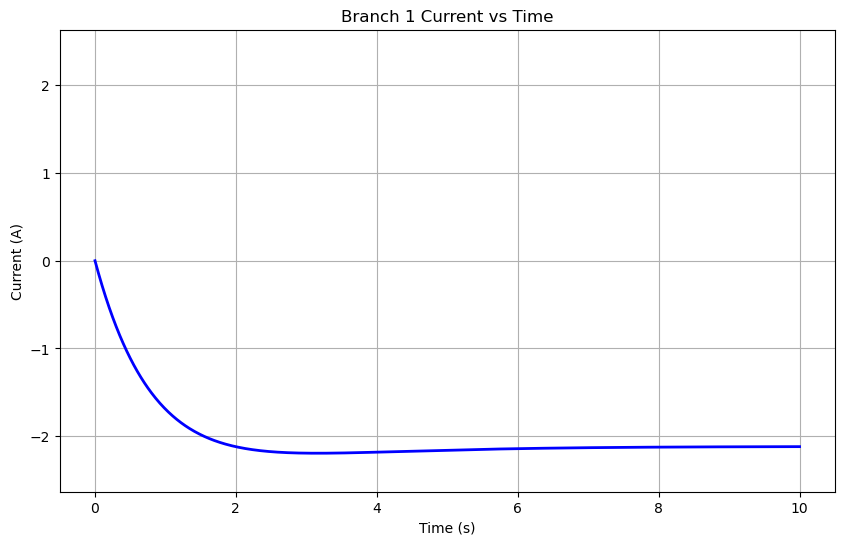


Plot Circuit Response:
1. Plot single branch response
2. Plot multiple branch responses
3. Exit plotting


Enter your choice (1-3):  1
Enter response type (current/voltage):  current
Enter start time (seconds):  0
Enter end time (seconds):  14.1
Enter branch number to plot:  1


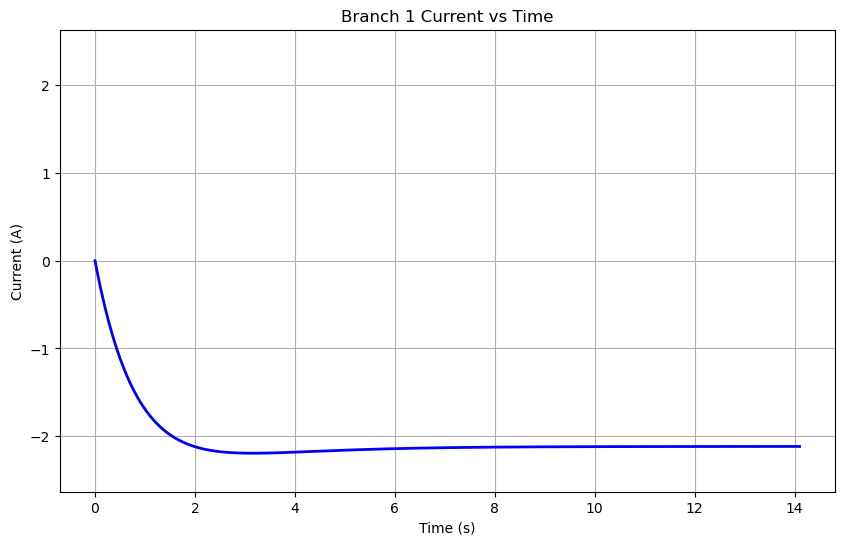


Plot Circuit Response:
1. Plot single branch response
2. Plot multiple branch responses
3. Exit plotting


Enter your choice (1-3):  3


In [102]:
plot_circuit_responses(time_domain_solutions)